In [1]:
import time
start_time = time.time()
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
from qiskit_algorithms.utils import algorithm_globals

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from functools import partial

In [3]:
from sklearn.datasets import load_iris
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
features = MinMaxScaler().fit_transform(features)
algorithm_globals.random_seed = 4701

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)
num_features = features.shape[1]

In [4]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

iris_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

iris_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=iris_feature_map)

In [5]:
data_descriptions = ["Full Features", "Missing Sepal Length", "Missing Sepal Width", "Missing Petal Length",
                     "Missing Petal Width"]

In [6]:
full_features = iris_data.data 

In [8]:
from qiskit_machine_learning.algorithms import QSVC

qsvc_full = QSVC(quantum_kernel=iris_kernel, probability=True)

qsvc_full.fit(train_features, train_labels)

qsvc_score = qsvc_full.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")
qsvc_full.save('quantum_classifiers/iris_qsvc.model')

QSVC classification test score: 0.8666666666666667


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms.utils import algorithm_globals
import time

qsvc_scores = {}
training_times = {}

for i, description in enumerate(data_descriptions):
    
    if i == 0:
        adjusted_features = full_features.copy()
    else:
        adjusted_features = np.delete(full_features, i-1, axis=1)
    
    
    num_features = adjusted_features.shape[1]
    
    adjusted_features = MinMaxScaler().fit_transform(adjusted_features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        adjusted_features, labels, train_size=0.8, random_state=algorithm_globals.random_seed)
    
    iris_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")
    iris_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=iris_feature_map)
    qsvc = QSVC(quantum_kernel=iris_kernel)
    
    
    start_time = time.time()
    qsvc.fit(train_features, train_labels)
    elapsed_time = time.time() - start_time
    training_times[description] = elapsed_time
    
    # Evaluate model performance
    qsvc_score = qsvc.score(test_features, test_labels)
    qsvc_scores[description] = qsvc_score
    
    print(f"{description} - QSVC classification test score: {qsvc_score}, Training time: {elapsed_time:.2f} seconds")



Full Features - QSVC classification test score: 0.8666666666666667, Training time: 50.44 seconds
Missing Sepal Length - QSVC classification test score: 0.9, Training time: 38.94 seconds
Missing Sepal Width - QSVC classification test score: 0.8666666666666667, Training time: 34.46 seconds
Missing Petal Length - QSVC classification test score: 0.9, Training time: 34.90 seconds
Missing Petal Width - QSVC classification test score: 0.8666666666666667, Training time: 33.74 seconds


In [ ]:
qsvc_scores.to_csv('qsvc_loo_scores.csv', index=False)

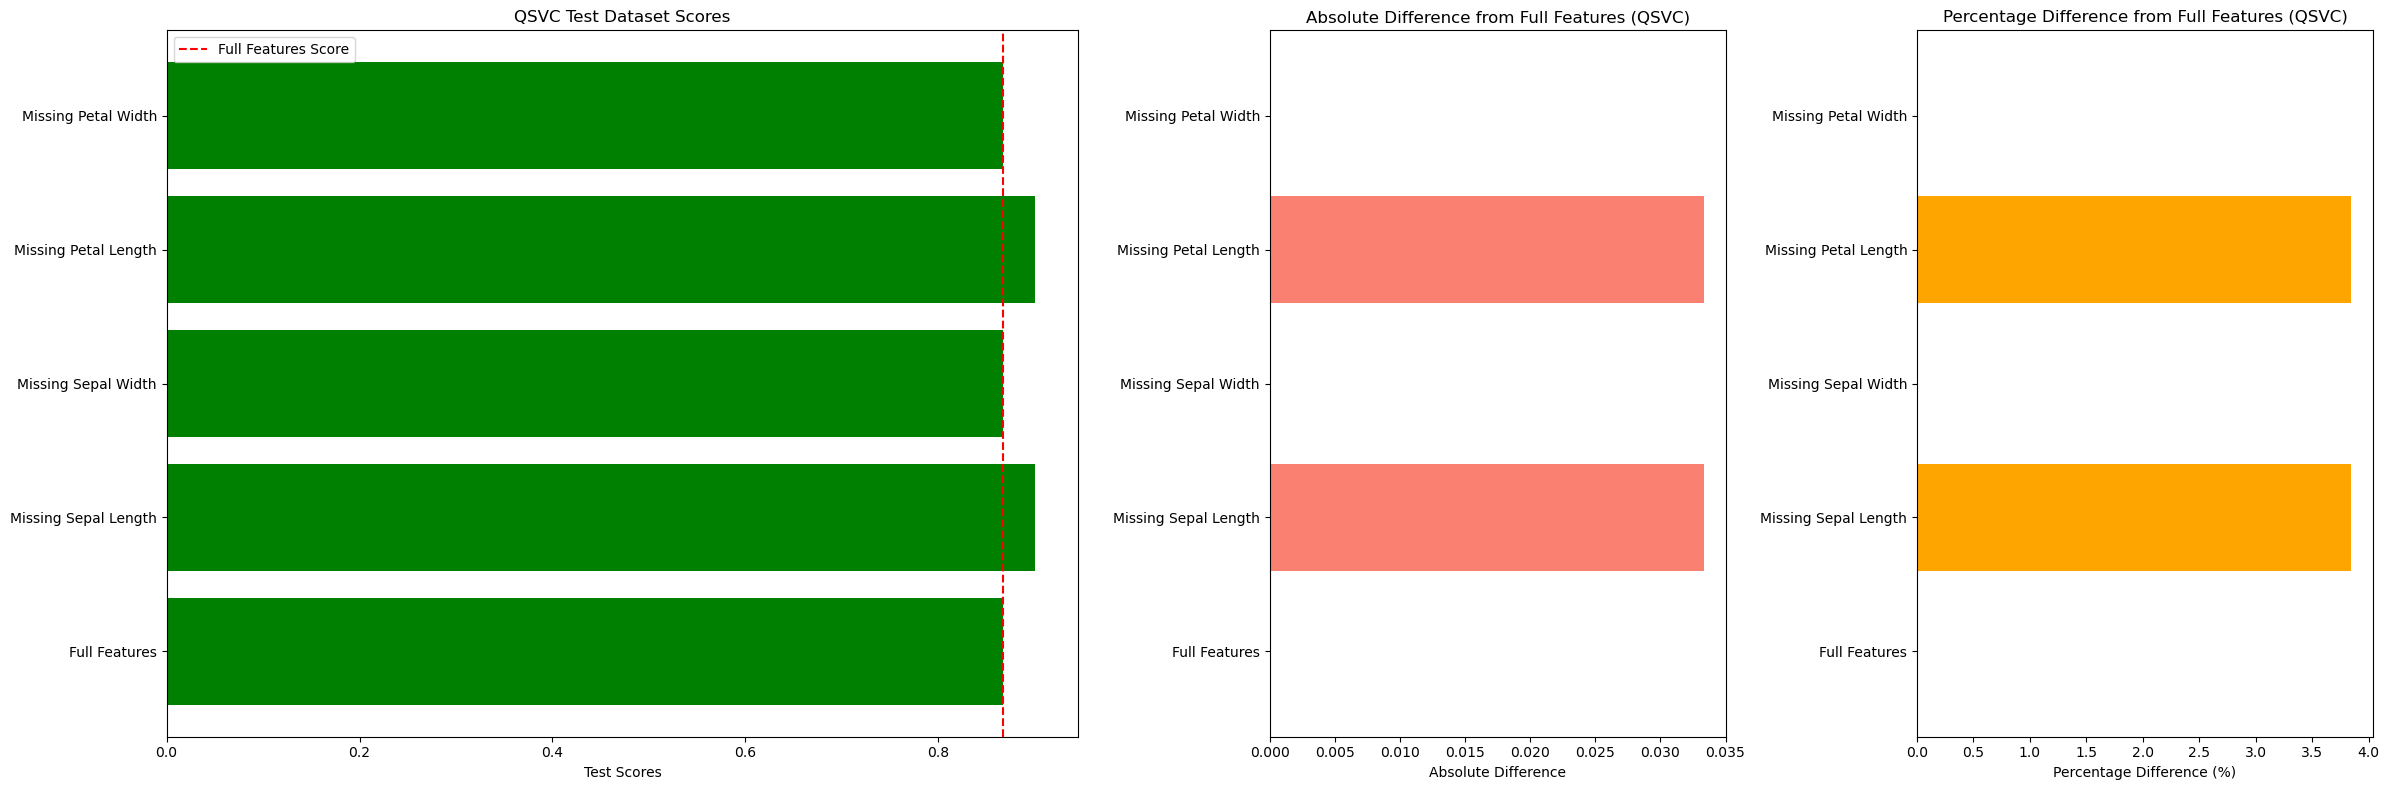

In [28]:

qscores = {
    'Full Features': {'Test': 0.8666666666666667, 'Training Time': 50.44},
    'Missing Sepal Length': {'Test': 0.9, 'Training Time': 38.94},
    'Missing Sepal Width': {'Test': 0.8666666666666667, 'Training Time': 34.46},
    'Missing Petal Length': {'Test': 0.9, 'Training Time': 34.90},
    'Missing Petal Width': {'Test': 0.8666666666666667, 'Training Time': 33.74}
}

# Calculate the absolute and percentage differences from the full features test score for QSVC
qfull_feature_score = qscores['Full Features']['Test']
for feature_set, score_info in qscores.items():
    if feature_set != 'Full Features':
        qabsolute_difference = score_info['Test'] - qfull_feature_score 
        qpercentage_difference = (qabsolute_difference / qfull_feature_score) * 100
        qscores[feature_set]['Absolute Difference'] = qabsolute_difference
        qscores[feature_set]['Percentage Difference'] = qpercentage_difference

# Prepare the data for plotting for QSVC
qcategories = list(qscores.keys())
qtest_scores = [score_info['Test'] for score_info in qscores.values()]
qabs_diff_scores = [score_info.get('Absolute Difference', 0) for score_info in qscores.values()]
qperc_diff_scores = [score_info.get('Percentage Difference', 0) for score_info in qscores.values()]
qtraining_times = [score_info['Training Time'] for score_info in qscores.values()]

# Plotting the visualizations for QSVC
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'width_ratios': [2, 1, 1]})

# Test Scores Bar Chart for QSVC
ax1.barh(qcategories, qtest_scores, color='green')
ax1.axvline(x=qfull_feature_score, color='red', linestyle='--', label='Full Features Score')
ax1.set_xlabel('Test Scores')
ax1.set_title('QSVC Test Dataset Scores')
ax1.legend()

# Absolute Difference Bar Chart for QSVC
ax2.barh(qcategories, qabs_diff_scores, color='salmon')
ax2.set_xlabel('Absolute Difference')
ax2.set_title('Absolute Difference from Full Features (QSVC)')

# Percentage Difference Bar Chart for QSVC
ax3.barh(qcategories, qperc_diff_scores, color='orange')
ax3.set_xlabel('Percentage Difference (%)')
ax3.set_title('Percentage Difference from Full Features (QSVC)')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [29]:
progress = {}
classical_scores = {}

for i, description in enumerate(data_descriptions):
    # Adjust features based on the description
    if i == 0:
        adjusted_features = full_features.copy()
    else:
        adjusted_features = np.delete(full_features, i-1, axis=1)
    
    # Update the number of features based on the adjusted features
    num_features = adjusted_features.shape[1]
    
    # Scale features and split data
    adjusted_features = MinMaxScaler().fit_transform(adjusted_features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        adjusted_features, labels, train_size=0.8, random_state=algorithm_globals.random_seed)
    
    # Initialize variables to store progress for the current dataset variant
    iterations = range(1, 101)  # Simulating for 100 iterations
    train_scores = []
    test_scores = []
    
    warnings.filterwarnings('ignore')
    
    # Loop over the range of iterations, incrementally training the SVC
    for i in iterations:
        svc = SVC(max_iter=i)
        svc.fit(train_features, train_labels)  # fit the model
        
        # Evaluate the model
        train_score_classical = svc.score(train_features, train_labels)
        test_score_classical = svc.score(test_features, test_labels)
        
        train_scores.append(train_score_classical)
        test_scores.append(test_score_classical)

    progress[description] = test_scores
    
    # Store the final scores for comparison
    classical_scores[description] = {
        "Training": train_score_classical,
        "Test": test_score_classical
    }


In [30]:
classical_scores

{'Full Features': {'Training': 0.9916666666666667, 'Test': 0.9},
 'Missing Sepal Length': {'Training': 0.9916666666666667, 'Test': 0.9},
 'Missing Sepal Width': {'Training': 0.9833333333333333, 'Test': 0.9},
 'Missing Petal Length': {'Training': 0.975, 'Test': 0.9333333333333333},
 'Missing Petal Width': {'Training': 0.9583333333333334,
  'Test': 0.9333333333333333}}

In [31]:
progress = {}
classical_scores = {}
scaler = MinMaxScaler()  # Initialize scaler once

for i, description in enumerate(data_descriptions):
    # Adjust features based on the description
    adjusted_features = full_features.copy() if i == 0 else np.delete(full_features, i-1, axis=1)
    
    # Scale features and split data
    adjusted_features = scaler.fit_transform(adjusted_features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        adjusted_features, labels, train_size=0.8, random_state=algorithm_globals.random_seed)
    
    train_scores, test_scores = [], []
    for iter in range(1, 101):  # Adjusted to 100 iterations
        svc = SVC(max_iter=iter).fit(train_features, train_labels)
        train_scores.append(svc.score(train_features, train_labels))
        test_scores.append(svc.score(test_features, test_labels))

    progress[description] = test_scores
    classical_scores[description] = {"Training": train_scores[-1], "Test": test_scores[-1]}

# Consider adding plotting code here to visualize `progress`


In [32]:
classical_scores

{'Full Features': {'Training': 0.9916666666666667, 'Test': 0.9},
 'Missing Sepal Length': {'Training': 0.9916666666666667, 'Test': 0.9},
 'Missing Sepal Width': {'Training': 0.9833333333333333, 'Test': 0.9},
 'Missing Petal Length': {'Training': 0.975, 'Test': 0.9333333333333333},
 'Missing Petal Width': {'Training': 0.9583333333333334,
  'Test': 0.9333333333333333}}

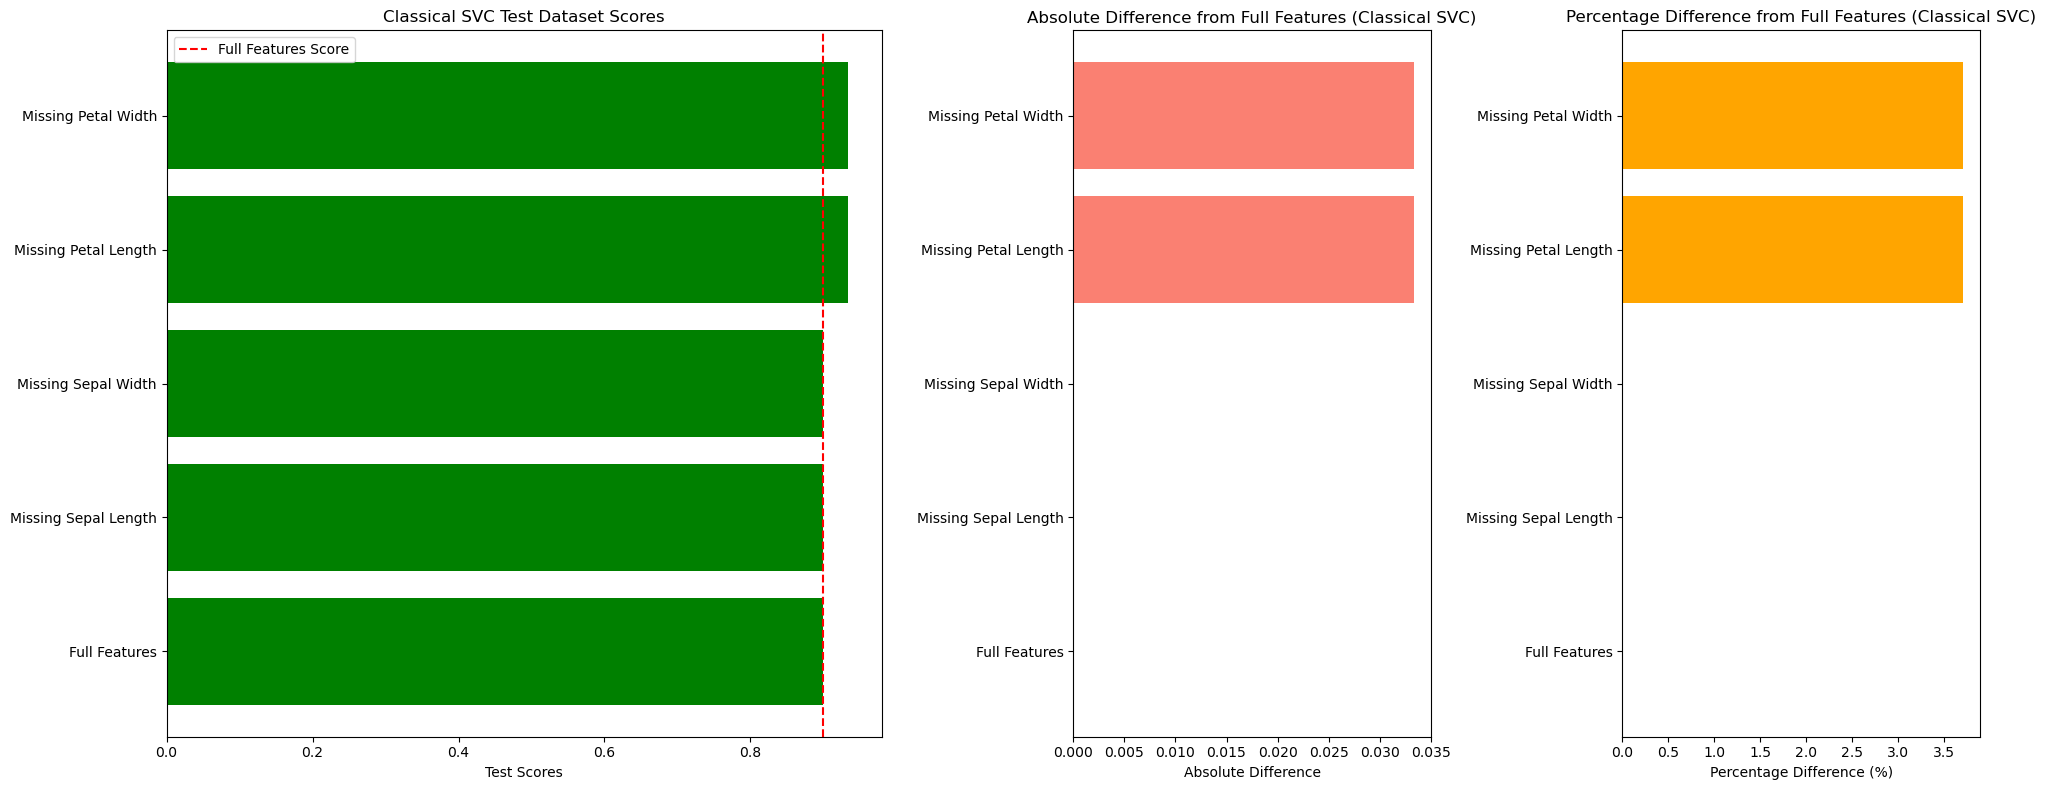

In [33]:
scores = {
    'Full Features': {'Test': 0.9},
    'Missing Sepal Length': {'Test': 0.9},
    'Missing Sepal Width': {'Test': 0.9},
    'Missing Petal Length': {'Test': 0.9333333333333333},
    'Missing Petal Width': {'Test': 0.9333333333333333}
}

# Now, calculate the absolute and percentage differences from the full features test score
full_feature_score = scores['Full Features']['Test']
for feature_set, score_info in scores.items():
    if feature_set != 'Full Features':
        absolute_difference = score_info['Test'] - full_feature_score 
        percentage_difference = (absolute_difference / full_feature_score) * 100
        scores[feature_set]['Absolute Difference'] = absolute_difference
        scores[feature_set]['Percentage Difference'] = percentage_difference

# Now we prepare the data for plotting
categories = list(scores.keys())
test_scores = [score_info['Test'] for score_info in scores.values()]
abs_diff_scores = [score_info.get('Absolute Difference', 0) for score_info in scores.values()]
perc_diff_scores = [score_info.get('Percentage Difference', 0) for score_info in scores.values()]

# Plotting the visualizations
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [2, 1, 1]})

# Test Scores Bar Chart
ax1.barh(categories, test_scores, color='green')
ax1.axvline(x=full_feature_score, color='red', linestyle='--', label='Full Features Score')
ax1.set_xlabel('Test Scores')
ax1.set_title('Classical SVC Test Dataset Scores')
ax1.legend()

# Absolute Difference Bar Chart
ax2.barh(categories, abs_diff_scores, color='salmon')
ax2.set_xlabel('Absolute Difference')
ax2.set_title('Absolute Difference from Full Features (Classical SVC)')

# Percentage Difference Bar Chart
ax3.barh(categories, perc_diff_scores, color='orange')
ax3.set_xlabel('Percentage Difference (%)')
ax3.set_title('Percentage Difference from Full Features (Classical SVC)')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


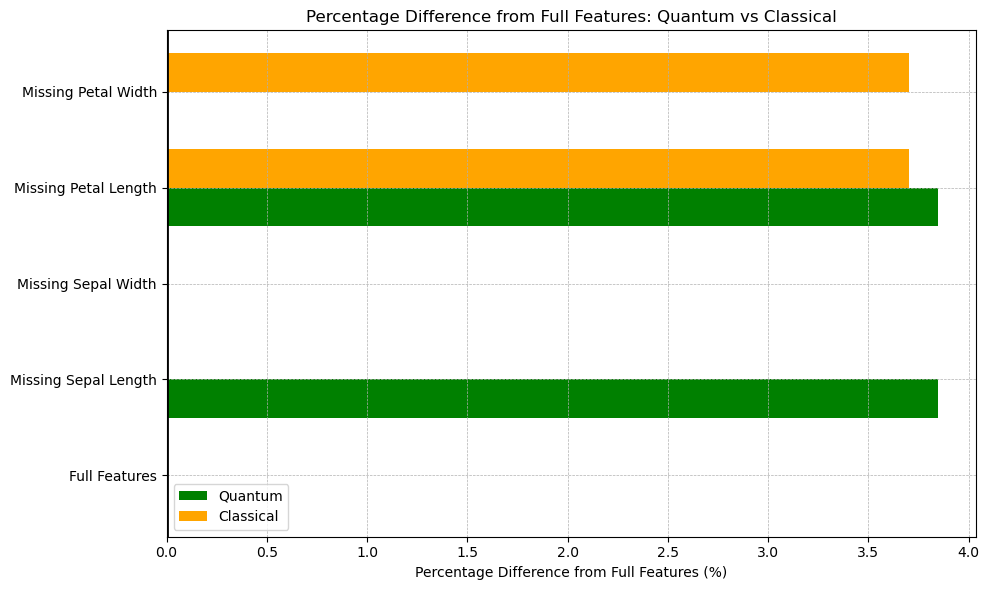

In [34]:
import numpy as np

# Since we do not have pandas DataFrame, we will use the lists created previously for this example
categories = qcategories  # Categories from the QSVC data
percent_differences_quantum = qperc_diff_scores  # Percentage differences from the QSVC data
percent_differences_classical = perc_diff_scores  # Percentage differences from the classical SVC data

# Creating the overlay plot with correct representation of positive and negative changes
fig, ax = plt.subplots(figsize=(10, 6))

# Setting positions for each category's bar groups
positions = np.arange(len(categories))

# Plotting percentage differences for quantum and classical with correct +/- representation
ax.barh(positions - 0.2, percent_differences_quantum, height=0.4, label='Quantum', color='green')
ax.barh(positions + 0.2, percent_differences_classical, height=0.4, label='Classical', color='orange')

# Setting labels, title, and customizing the axes and legend
ax.set(yticks=positions, yticklabels=categories)
ax.set_title('Percentage Difference from Full Features: Quantum vs Classical')
ax.set_xlabel('Percentage Difference from Full Features (%)')
ax.legend()

# Adding grid lines and emphasizing the line at x = 0 to highlight no change
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [47]:
from sklearn.inspection import permutation_importance
r = permutation_importance(qsvc_full, test_features, test_labels,
                           n_repeats=30,
                           random_state=0)

In [48]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{iris_data.feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

petal length (cm)0.396 +/- 0.077
sepal length (cm)0.172 +/- 0.048


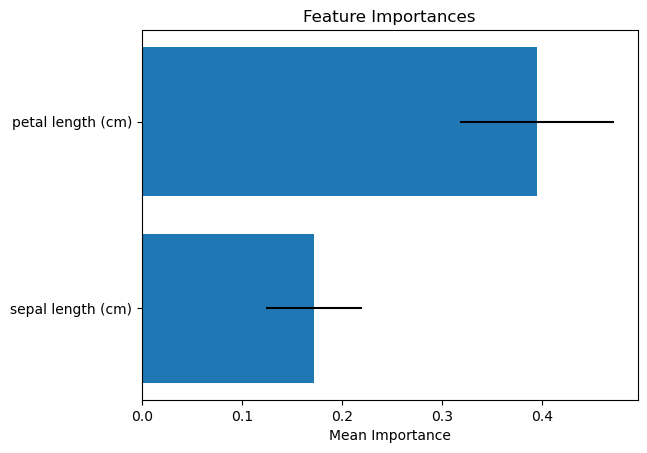

In [49]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = iris_data.feature_names

# Indices of features, sorted by importance
sorted_idx = r.importances_mean.argsort()[::-1]

# Prepare labels and their corresponding importance scores and std deviations
labels = np.array(feature_names)[sorted_idx]
importance_means = r.importances_mean[sorted_idx]
importance_stds = r.importances_std[sorted_idx]

significant_indices = [i for i in range(len(importance_means)) if importance_means[i] - 2 * importance_stds[i] > 0]
significant_labels = labels[significant_indices]
significant_means = importance_means[significant_indices]
significant_stds = importance_stds[significant_indices]


plt.barh(significant_labels, significant_means, xerr=significant_stds, align='center')
plt.xlabel('Mean Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()
